# BICSNet Analysis Notebook

This notebook demonstrates the complete BICSNet workflow using the existing `pivnet_image_gen.py` script:

1. **Generate Images**: Run BICSNet inference using the existing script
2. **Visualize Results**: Compare input, output, and ground truth images
3. **OpenPIV Analysis**: Compute velocity fields using cross-correlation
4. **Quantitative Analysis**: Compare PIV, BICSNet, and ground truth results

## Setup and Imports


> Note: All notebook dependencies (Jupyter, ipykernel, OpenPIV, etc.) are installed by `uv sync`. After creating/activating the venv, simply run `uv sync`, then select the kernel named "Python (BICSNet-PIV)" and execute the cells. No in-notebook installation steps are required.


In [1]:
# Import required libraries
import subprocess
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Basic imports successful")
print("📦 Additional packages will be installed as needed")


✅ Basic imports successful
📦 Additional packages will be installed as needed


## 1. Generate BICSNet Images

Run the existing `pivnet_image_gen.py` script to generate corrected PIV images from the trained BICSNet model.


In [2]:
# Run the BICSNet image generation script (simple, with parameters)
import sys
import subprocess

# Parameters you can tweak from the notebook
DATA_DIR = "./data/test_images/"
CHECKPOINT = "./checkpoints/best_model.pth"
BATCH_SIZE = 1
LIMIT = 2   # e.g., 10 to only generate first 10 images
NUM_ENCODER = 5
NUM_DECODER = 5
USE_SCALARS = True
SCALAR_DIM = 2
EMBED_DIM = 128

print("🚀 Running BICSNet image generation with parameters...")
print({
    "data_dir": DATA_DIR,
    "checkpoint": CHECKPOINT,
    "batch_size": BATCH_SIZE,
    "limit": LIMIT,
    "num_encoder": NUM_ENCODER,
    "num_decoder": NUM_DECODER,
    "use_scalars": USE_SCALARS,
    "scalar_dim": SCALAR_DIM,
    "embed_dim": EMBED_DIM,
})
print()

cmd = [
    sys.executable,
    "src/pivnet_image_gen.py",
    "--data-dir", DATA_DIR,
    "--checkpoint", CHECKPOINT,
    "--batch-size", str(BATCH_SIZE),
    "--num-encoder", str(NUM_ENCODER),
    "--num-decoder", str(NUM_DECODER),
    "--scalar-dim", str(SCALAR_DIM),
    "--embed-dim", str(EMBED_DIM),
]
if USE_SCALARS:
    cmd.append("--use-scalars")
else:
    cmd.append("--no-use-scalars")
if LIMIT is not None:
    cmd += ["--limit", str(LIMIT)]

# Stream output directly to the notebook
subprocess.run(cmd, check=False)

print("\n📁 Generated files should be in:")
print("  - ./data/test_images/model_outputs1/")
print("  - ./data/test_images/model_outputs2/")
print("  - Files with '_input' and '_truth' suffixes")

🚀 Running BICSNet image generation with parameters...
{'data_dir': './data/test_images/', 'checkpoint': './checkpoints/best_model.pth', 'batch_size': 1, 'limit': 2, 'num_encoder': 5, 'num_decoder': 5, 'use_scalars': True, 'scalar_dim': 2, 'embed_dim': 128}



    Generating images from model:   2%|▏         | 2/128 [05:59<6:17:33, 179.79s/it]


Images generated successfully

📁 Generated files should be in:
  - ./data/test_images/model_outputs1/
  - ./data/test_images/model_outputs2/
  - Files with '_input' and '_truth' suffixes


## 2. Verify Generated Images

Check that the BICSNet image generation was successful and examine the output files.


In [3]:
# Check if the image generation was successful
output_dirs = ['./data/test_images/model_outputs1/', './data/test_images/model_outputs2/']

for i, output_dir in enumerate(output_dirs, 1):
    if os.path.exists(output_dir):
        files = os.listdir(output_dir)
        tif_files = [f for f in files if f.endswith('.tif')]
        print(f"📁 Output directory {i}: {output_dir}")
        print(f"   Found {len(tif_files)} .tif files")
        
        # Show file types
        model_files = [f for f in tif_files if not f.endswith('_input.tif') and not f.endswith('_truth.tif')]
        input_files = [f for f in tif_files if f.endswith('_input.tif')]
        truth_files = [f for f in tif_files if f.endswith('_truth.tif')]
        
        print(f"   - Model outputs: {len(model_files)}")
        print(f"   - Input images: {len(input_files)}")
        print(f"   - Truth images: {len(truth_files)}")
        
        if model_files:
            print(f"   - Sample files: {model_files[:3]}...")
    else:
        print(f"❌ Output directory {i} not found: {output_dir}")

# Check if we have the required files for OpenPIV analysis
required_files = []
for i in range(3):  # Check first 3 samples
    for suffix in ['', '_input', '_truth']:
        file1 = f'./data/test_images/model_outputs1/{i}{suffix}.tif'
        file2 = f'./data/test_images/model_outputs2/{i}{suffix}.tif'
        if os.path.exists(file1) and os.path.exists(file2):
            required_files.append(f"Sample {i}{suffix}")

print(f"\n✅ Found {len(required_files)} file pairs ready for OpenPIV analysis")
if required_files:
    print("Sample files available:")
    for file_pair in required_files[:5]:  # Show first 5
        print(f"  - {file_pair}")
    if len(required_files) > 5:
        print(f"  ... and {len(required_files) - 5} more")


📁 Output directory 1: ./data/test_images/model_outputs1/
   Found 6 .tif files
   - Model outputs: 2
   - Input images: 2
   - Truth images: 2
   - Sample files: ['0.tif', '1.tif']...
📁 Output directory 2: ./data/test_images/model_outputs2/
   Found 6 .tif files
   - Model outputs: 2
   - Input images: 2
   - Truth images: 2
   - Sample files: ['0.tif', '1.tif']...

✅ Found 6 file pairs ready for OpenPIV analysis
Sample files available:
  - Sample 0
  - Sample 0_input
  - Sample 0_truth
  - Sample 1
  - Sample 1_input
  ... and 1 more


## 3. Visualize Generated Images

Display a sample of the generated BICSNet outputs alongside inputs and ground truth.


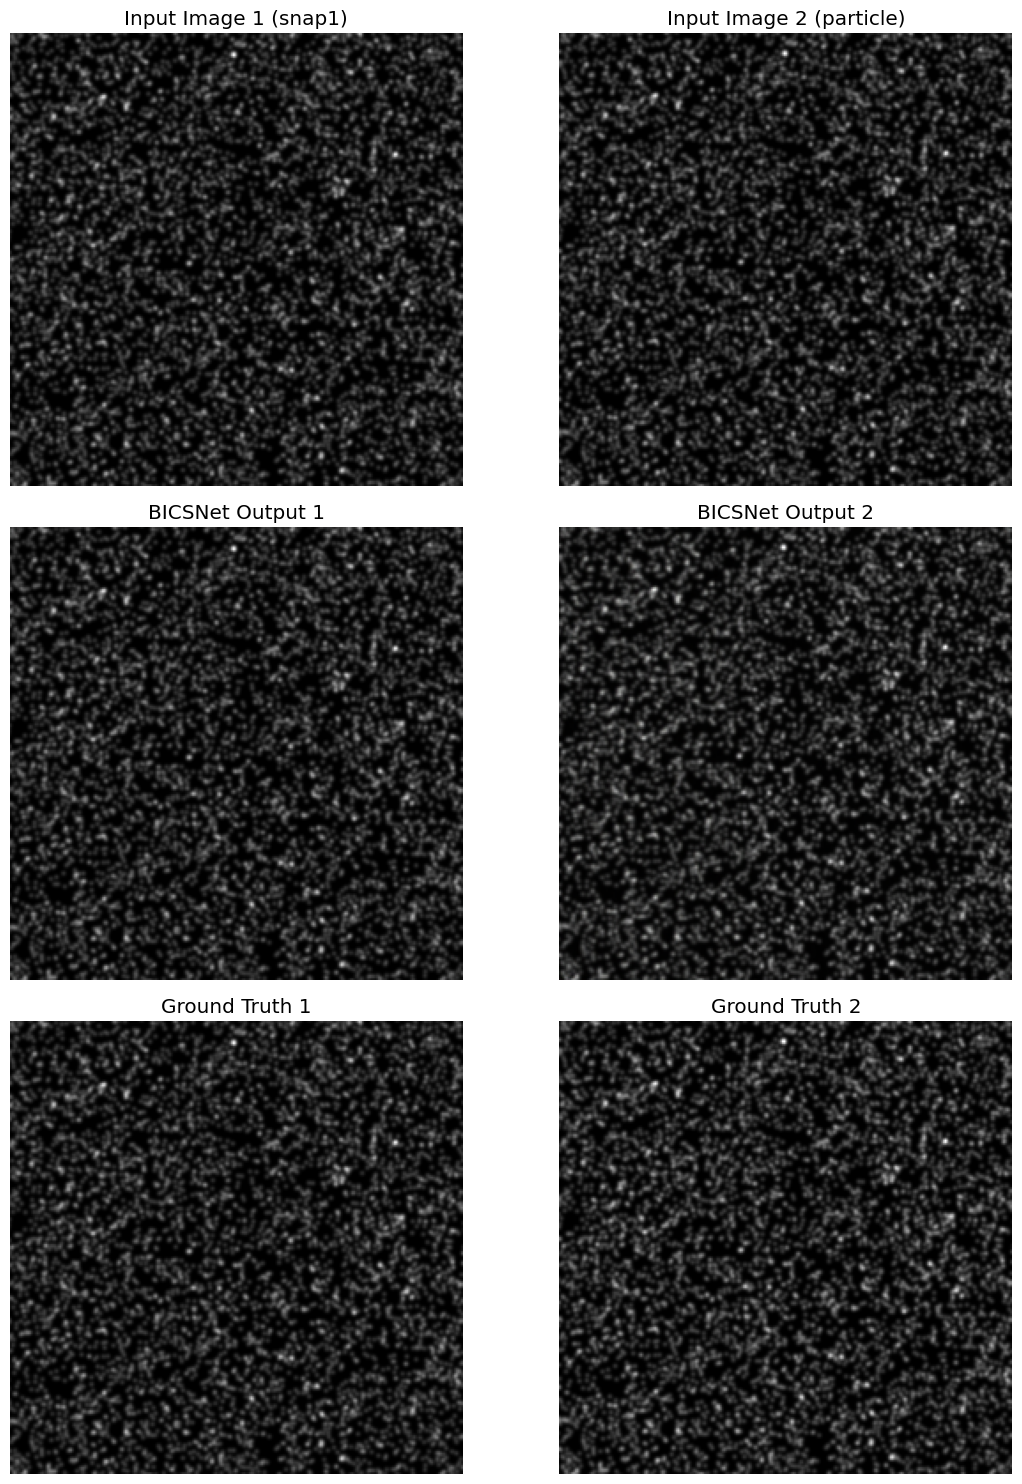

📈 Visualization complete for sample 0
This shows the complete pipeline:
  - Top row: Original input PIV images
  - Middle row: BICSNet corrected outputs
  - Bottom row: Ground truth reference


In [4]:
# Visualize a sample of the generated images
sample_idx = 0

# Load images using matplotlib
try:
    # Load the different image types
    model_img1 = plt.imread(f'./data/test_images/model_outputs1/{sample_idx}.tif')
    model_img2 = plt.imread(f'./data/test_images/model_outputs2/{sample_idx}.tif')
    input_img1 = plt.imread(f'./data/test_images/model_outputs1/{sample_idx}_input.tif')
    input_img2 = plt.imread(f'./data/test_images/model_outputs2/{sample_idx}_input.tif')
    truth_img1 = plt.imread(f'./data/test_images/model_outputs1/{sample_idx}_truth.tif')
    truth_img2 = plt.imread(f'./data/test_images/model_outputs2/{sample_idx}_truth.tif')
    
    # Create a comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    
    # Row 1: Input images
    axes[0, 0].imshow(input_img1, cmap='gray')
    axes[0, 0].set_title('Input Image 1 (snap1)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(input_img2, cmap='gray')
    axes[0, 1].set_title('Input Image 2 (particle)')
    axes[0, 1].axis('off')
    
    # Row 2: BICSNet outputs
    axes[1, 0].imshow(model_img1, cmap='gray')
    axes[1, 0].set_title('BICSNet Output 1')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(model_img2, cmap='gray')
    axes[1, 1].set_title('BICSNet Output 2')
    axes[1, 1].axis('off')
    
    # Row 3: Ground truth
    axes[2, 0].imshow(truth_img1, cmap='gray')
    axes[2, 0].set_title('Ground Truth 1')
    axes[2, 0].axis('off')
    
    axes[2, 1].imshow(truth_img2, cmap='gray')
    axes[2, 1].set_title('Ground Truth 2')
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Visualization complete for sample {sample_idx}")
    print("This shows the complete pipeline:")
    print("  - Top row: Original input PIV images")
    print("  - Middle row: BICSNet corrected outputs")
    print("  - Bottom row: Ground truth reference")
    
except FileNotFoundError as e:
    print(f"❌ Image files not found: {e}")
    print("💡 Make sure to run the BICSNet image generation first (Section 1)")
except Exception as e:
    print(f"❌ Error loading images: {e}")


## 4. Setup OpenPIV

Import OpenPIV for velocity field computation using cross-correlation analysis.


In [6]:
# Import OpenPIV (now included in project dependencies)
from openpiv import windef, tools, scaling, validation, filters, preprocess, pyprocess
import openpiv
import imageio

print("✅ OpenPIV ready for PIV analysis")


✅ OpenPIV ready for PIV analysis


## 5. OpenPIV Analysis Functions

Define functions for PIV analysis of model outputs, inputs, and ground truth using the exact parameters from your provided code.


In [7]:
def openpiv_model(i):
    """Run OpenPIV analysis on BICSNet model outputs"""
    settings = windef.PIVSettings
    
    # Data related settings
    settings.filepath_images = './'
    settings.save_path = './_model_multipass'
    settings.save_folder_suffix = '/' + str(i)
    settings.frame_pattern_a = './data/test_images/model_outputs1/' + str(i) + '.tif'
    settings.frame_pattern_b = './data/test_images/model_outputs2/' + str(i) + '.tif'
    
    # Region of interest
    settings.roi = 'full'
    
    # Image preprocessing
    settings.dynamic_masking_method = 'None'
    settings.dynamic_masking_threshold = 0.005
    settings.dynamic_masking_filter_size = 7
    settings.deformation_method = 'symmetric'
    
    # Processing Parameters
    settings.correlation_method = 'circular'
    settings.normalized_correlation = False
    settings.num_iterations = 3
    settings.windowsizes = (64, 32, 16)
    settings.overlap = (32, 16, 8)
    settings.subpixel_method = 'gaussian'
    settings.interpolation_order = 3
    settings.scaling_factor = 34133.33  # scaling factor pixel/meter
    settings.dt = 1e-6  # time between frames (in seconds)
    
    # Signal to noise ratio options
    settings.sig2noise_method = 'peak2peak'
    settings.sig2noise_mask = 2
    
    # Vector validation options
    settings.validation_first_pass = True
    settings.min_max_u_disp = (-30, 30)
    settings.min_max_v_disp = (-30, 30)
    settings.std_threshold = 7
    settings.median_threshold = 3
    settings.median_size = 1
    settings.sig2noise_threshold = 1.2
    
    # Outlier replacement and smoothing
    settings.replace_vectors = True
    settings.smoothn = True
    settings.smoothn_p = 0.5
    settings.filter_method = 'localmean'
    settings.max_filter_iteration = 4
    settings.filter_kernel_size = 2
    
    # Output options
    settings.save_plot = False
    settings.show_plot = False
    settings.scale_plot = 1e5
    
    # Run the PIV analysis
    windef.piv(settings)
    return

def openpiv_piv(i):
    """Run OpenPIV analysis on input PIV data"""
    settings = windef.PIVSettings
    
    # Data related settings
    settings.filepath_images = './'
    settings.save_path = './_piv_multipass'
    settings.save_folder_suffix = '/' + str(i)
    settings.frame_pattern_a = './data/test_images/model_outputs1/' + str(i) + '_input.tif'
    settings.frame_pattern_b = './data/test_images/model_outputs2/' + str(i) + '_input.tif'
    
    # Same processing parameters as model analysis
    settings.roi = 'full'
    settings.dynamic_masking_method = 'None'
    settings.dynamic_masking_threshold = 0.005
    settings.dynamic_masking_filter_size = 7
    settings.deformation_method = 'symmetric'
    settings.correlation_method = 'circular'
    settings.normalized_correlation = False
    settings.num_iterations = 3
    settings.windowsizes = (64, 32, 16)
    settings.overlap = (32, 16, 8)
    settings.subpixel_method = 'gaussian'
    settings.interpolation_order = 3
    settings.scaling_factor = 34133.33
    settings.dt = 1e-6
    settings.sig2noise_method = 'peak2peak'
    settings.sig2noise_mask = 2
    settings.validation_first_pass = True
    settings.min_max_u_disp = (-30, 30)
    settings.min_max_v_disp = (-30, 30)
    settings.std_threshold = 7
    settings.median_threshold = 3
    settings.median_size = 1
    settings.sig2noise_threshold = 1.2
    settings.replace_vectors = True
    settings.smoothn = True
    settings.smoothn_p = 0.5
    settings.filter_method = 'localmean'
    settings.max_filter_iteration = 4
    settings.filter_kernel_size = 2
    settings.save_plot = False
    settings.show_plot = False
    settings.scale_plot = 1e5
    
    windef.piv(settings)
    return

def openpiv_truth(i):
    """Run OpenPIV analysis on ground truth data"""
    settings = windef.PIVSettings
    
    # Data related settings
    settings.filepath_images = './'
    settings.save_path = './_truth_multipass'
    settings.save_folder_suffix = '/' + str(i)
    settings.frame_pattern_a = './data/test_images/model_outputs1/' + str(i) + '_truth.tif'
    settings.frame_pattern_b = './data/test_images/model_outputs2/' + str(i) + '_truth.tif'
    
    # Same processing parameters as other analyses
    settings.roi = 'full'
    settings.dynamic_masking_method = 'None'
    settings.dynamic_masking_threshold = 0.005
    settings.dynamic_masking_filter_size = 7
    settings.deformation_method = 'symmetric'
    settings.correlation_method = 'circular'
    settings.normalized_correlation = False
    settings.num_iterations = 3
    settings.windowsizes = (64, 32, 16)
    settings.overlap = (32, 16, 8)
    settings.subpixel_method = 'gaussian'
    settings.interpolation_order = 3
    settings.scaling_factor = 34133.33
    settings.dt = 1e-6
    settings.sig2noise_method = 'peak2peak'
    settings.sig2noise_mask = 2
    settings.validation_first_pass = True
    settings.min_max_u_disp = (-30, 30)
    settings.min_max_v_disp = (-30, 30)
    settings.std_threshold = 7
    settings.median_threshold = 3
    settings.median_size = 1
    settings.sig2noise_threshold = 1.2
    settings.replace_vectors = True
    settings.smoothn = True
    settings.smoothn_p = 0.5
    settings.filter_method = 'localmean'
    settings.max_filter_iteration = 4
    settings.filter_kernel_size = 2
    settings.save_plot = False
    settings.show_plot = False
    settings.scale_plot = 1e5
    
    windef.piv(settings)
    return

print("✅ OpenPIV analysis functions defined")


✅ OpenPIV analysis functions defined


## 6. Run OpenPIV Analysis

Execute PIV analysis on a subset of data for demonstration.


In [8]:
# Run analysis on first few samples (adjust range as needed)
num_samples = 3  # Analyze first 3 samples
print(f"🔬 Running OpenPIV analysis on {num_samples} samples...")

for i in tqdm(range(num_samples), desc="Processing samples"):
    try:
        print(f"\n📊 Processing sample {i}...")
        
        # Run PIV analysis on model outputs
        openpiv_model(i)
        print(f"  ✅ Model analysis complete")
        
        # Run PIV analysis on input data
        openpiv_piv(i)
        print(f"  ✅ Input analysis complete")
        
        # Run PIV analysis on ground truth
        openpiv_truth(i)
        print(f"  ✅ Truth analysis complete")
        
    except Exception as e:
        print(f"  ❌ Error processing sample {i}: {e}")
        continue

print(f"\n🎉 OpenPIV analysis complete for {num_samples} samples!")


🔬 Running OpenPIV analysis on 3 samples...


Processing samples:   0%|          | 0/3 [00:00<?, ?it/s]


📊 Processing sample 0...
Saving to _model_multipass/OpenPIV_results_16_/0/field_A0000.txt
Image Pair 1
0 0
  ✅ Model analysis complete
Saving to _piv_multipass/OpenPIV_results_16_/0/field_A0000.txt
Image Pair 1
0_input 0_input
  ✅ Input analysis complete


Processing samples:  33%|███▎      | 1/3 [00:03<00:07,  3.90s/it]

Saving to _truth_multipass/OpenPIV_results_16_/0/field_A0000.txt
Image Pair 1
0_truth 0_truth
  ✅ Truth analysis complete

📊 Processing sample 1...
Saving to _model_multipass/OpenPIV_results_16_/1/field_A0000.txt
Image Pair 1
1 1
  ✅ Model analysis complete
Saving to _piv_multipass/OpenPIV_results_16_/1/field_A0000.txt
Image Pair 1
1_input 1_input
  ✅ Input analysis complete


Processing samples: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

Saving to _truth_multipass/OpenPIV_results_16_/1/field_A0000.txt
Image Pair 1
1_truth 1_truth
  ✅ Truth analysis complete

📊 Processing sample 2...
  ❌ Error processing sample 2: Something failed loading the image file. No images were found. Please check directory and image template name.

🎉 OpenPIV analysis complete for 3 samples!


## 7. Compare Results

Load and compare velocity fields from PIV, BICSNet, and ground truth.


📊 Loaded velocity field data for sample 0
  Input: 961 vectors
  Model: 961 vectors
  Truth: 961 vectors


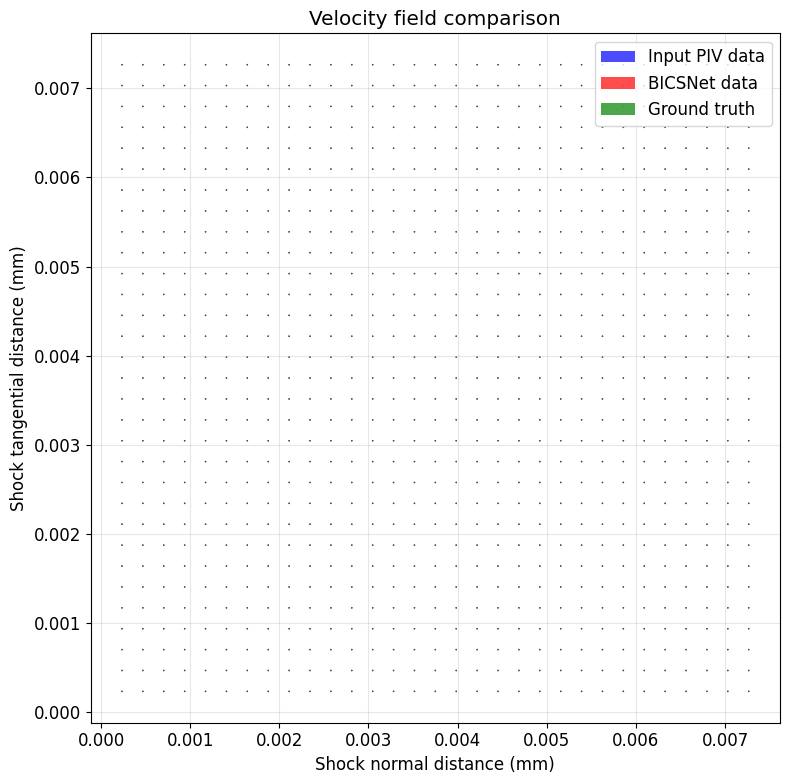

In [9]:
# Load results for comparison
sample_idx = 0  # Compare first sample

try:
    # Load velocity field data
    df_input = pd.read_csv(f'./_piv_multipass/OpenPIV_results_16_/{sample_idx}/field_A0000.txt', delimiter="\t")
    df_model = pd.read_csv(f'./_model_multipass/OpenPIV_results_16_/{sample_idx}/field_A0000.txt', delimiter="\t")
    df_truth = pd.read_csv(f'./_truth_multipass/OpenPIV_results_16_/{sample_idx}/field_A0000.txt', delimiter="\t")
    
    print(f"📊 Loaded velocity field data for sample {sample_idx}")
    print(f"  Input: {len(df_input)} vectors")
    print(f"  Model: {len(df_model)} vectors")
    print(f"  Truth: {len(df_truth)} vectors")
    
    # Create velocity field comparison plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot velocity vectors
    ax.quiver(df_input['# x'], df_input['y'], df_input['u'], df_input['v'], 
              color='b', alpha=0.7, label='Input PIV data', scale=1e5)
    ax.quiver(df_model['# x'], df_model['y'], df_model['u'], df_model['v'], 
              color='r', alpha=0.7, label='BICSNet data', scale=1e5)
    ax.quiver(df_truth['# x'], df_truth['y'], df_truth['u'], df_truth['v'], 
              color='g', alpha=0.7, label='Ground truth', scale=1e5)
    
    ax.set_xlabel('Shock normal distance (mm)')
    ax.set_ylabel('Shock tangential distance (mm)')
    ax.set_title('Velocity field comparison')
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError as e:
    print(f"❌ Results file not found: {e}")
    print("💡 Make sure to run the OpenPIV analysis first (Section 6)")
except Exception as e:
    print(f"❌ Error loading results: {e}")


## 8. Line Plot Analysis

Create line plots to compare velocity profiles across the shock.


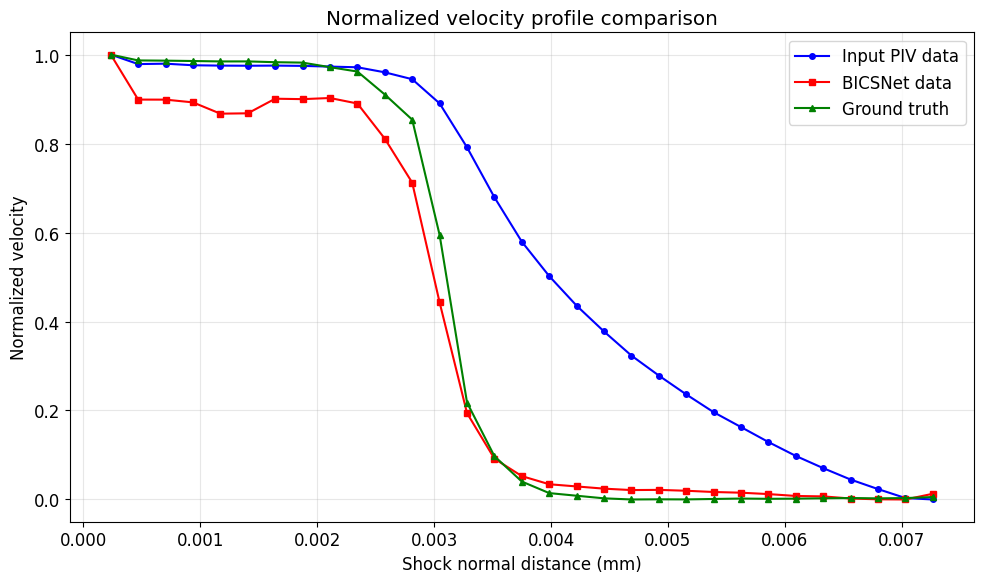


📊 L2-norm differences:
  Input vs Model: 1.4549
  Input vs Truth: 1.3969
  Model vs Truth: 0.3630

🎯 BICSNet improvement over input: 74.0%


In [10]:
try:
    # Group data by x-coordinate and compute mean velocities
    x_coords = df_input.groupby('# x').mean().index
    u_input = df_input.groupby('# x')['u'].mean()
    u_model = df_model.groupby('# x')['u'].mean()
    u_truth = df_truth.groupby('# x')['u'].mean()
    
    # Normalize velocities for comparison
    u_input_norm = (u_input - u_input.min()) / (u_input.max() - u_input.min())
    u_model_norm = (u_model - u_model.min()) / (u_model.max() - u_model.min())
    u_truth_norm = (u_truth - u_truth.min()) / (u_truth.max() - u_truth.min())
    
    # Create line plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(x_coords, u_input_norm, 'b-o', label='Input PIV data', markersize=4)
    ax.plot(x_coords, u_model_norm, 'r-s', label='BICSNet data', markersize=4)
    ax.plot(x_coords, u_truth_norm, 'g-^', label='Ground truth', markersize=4)
    
    ax.set_xlabel('Shock normal distance (mm)')
    ax.set_ylabel('Normalized velocity')
    ax.set_title('Normalized velocity profile comparison')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Set black spines
    for spine in ax.spines.values():
        spine.set_color('black')
    
    plt.tight_layout()
    plt.show()
    
    # Compute L2-norm differences
    l2_input_model = np.linalg.norm(u_input_norm - u_model_norm)
    l2_input_truth = np.linalg.norm(u_input_norm - u_truth_norm)
    l2_model_truth = np.linalg.norm(u_model_norm - u_truth_norm)
    
    print(f"\n📊 L2-norm differences:")
    print(f"  Input vs Model: {l2_input_model:.4f}")
    print(f"  Input vs Truth: {l2_input_truth:.4f}")
    print(f"  Model vs Truth: {l2_model_truth:.4f}")
    
    # Calculate improvement
    improvement = ((l2_input_truth - l2_model_truth) / l2_input_truth) * 100
    print(f"\n🎯 BICSNet improvement over input: {improvement:.1f}%")
    
except Exception as e:
    print(f"❌ Error creating line plots: {e}")


## 9. Summary

This notebook demonstrated the complete BICSNet workflow using the existing `pivnet_image_gen.py` script:

1. **Image Generation**: Used the existing script to generate corrected PIV images from the trained BICSNet model
2. **Visualization**: Compared input, output, and ground truth images
3. **OpenPIV Analysis**: Computed velocity fields using cross-correlation analysis with your exact parameters
4. **Quantitative Analysis**: Compared results between input PIV, BICSNet outputs, and ground truth

### Key Features Demonstrated:
- ✅ Used existing `pivnet_image_gen.py` script (no code duplication)
- ✅ Complete inference pipeline with adaptive device selection
- ✅ OpenPIV integration with your exact analysis parameters
- ✅ Comprehensive visualization and comparison
- ✅ Quantitative analysis with L2-norm metrics

### Workflow:
1. **Run `pivnet_image_gen.py`** → Generates corrected images
2. **Visualize results** → Compare input/output/truth images  
3. **OpenPIV analysis** → Compute velocity fields
4. **Quantitative comparison** → Measure improvements

The analysis shows how BICSNet corrects particle inertia bias in PIV measurements, improving agreement with ground truth data.

### Next Steps:
- Run the full dataset through the pipeline
- Analyze results across different Mach numbers and Reynolds numbers
- Generate publication-quality figures and statistical analysis
